In [1]:
import difflib
import importlib
import math
import random
import string

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from PIL import Image
from skimage import transform as skimage_tf, exposure
import IPython.display
from IPython.display import Image
from tqdm import tqdm
import leven

import gluonnlp as nlp
import mxnet as mx
from mxnet.gluon.data.vision import datasets, transforms

from recognization.ocr.utils.preprocess import histogram

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

# original image
image_name = "../../elyaz2.jpeg"
image = mx.image.imread(image_name, 0)  # 0 is grayscale

(584, 1532)


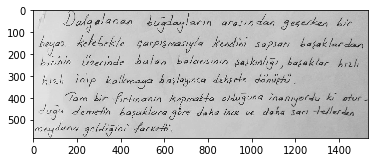

In [3]:
image = image[..., 0]
print(image.shape)
# gray_image = cv2.cvtColor(image.asnumpy(), cv2.COLOR_BGR2GRAY)
# print(gray_image.shape)
plt.imshow(image.asnumpy(), cmap="gray")
plt.show()

In [4]:
# image = np.swapaxes(image, 0, 2)
# image = np.swapaxes(image, 1, 2)
# print(image.shape)
# image = image[np.newaxis, :]
# print(image.shape)
# image = mx.nd.array(image)

In [5]:
print('Data Shape: ', image.shape)
print('Data Type: %s' % image.dtype)
print('Min: %.3f, Max: %.3f' % (image.asnumpy().min(), image.asnumpy().max()))

Data Shape:  (584, 1532)
Data Type: <class 'numpy.uint8'>
Min: 16.000, Max: 215.000


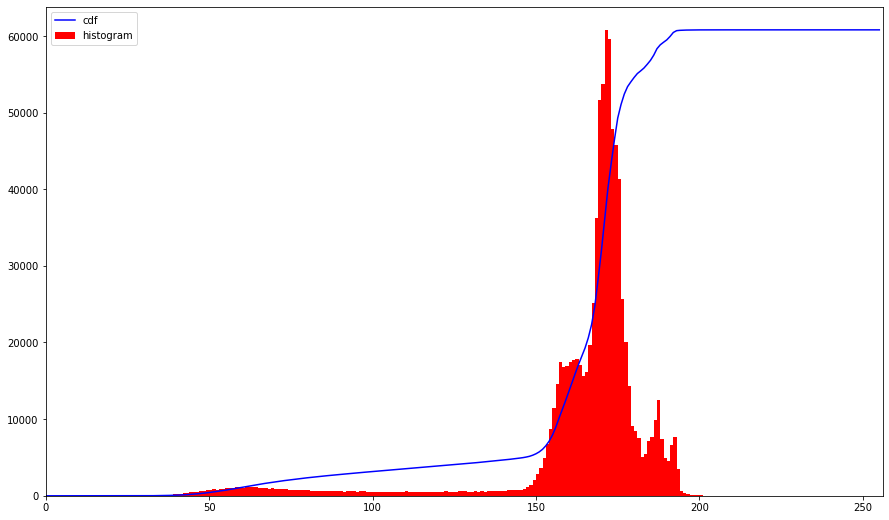

In [6]:
histogram(image.asnumpy(), show=True)

Histogram is wrong

In [7]:
# Thresholding test

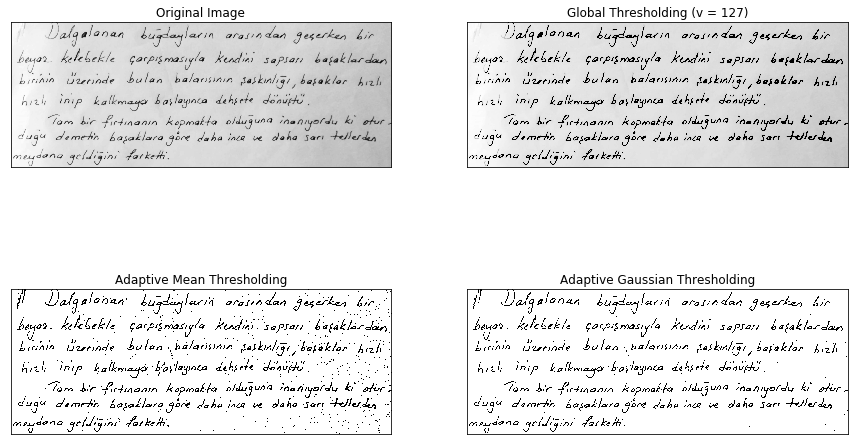

In [8]:
def thresholds(image, bottom=127, top=255):
    img = cv2.medianBlur(image,5)
    ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO+cv2.THRESH_OTSU)  # Global thresholding
    th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
                cv2.THRESH_BINARY,11,2)
    th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                cv2.THRESH_BINARY,11,2)
    return img, th1, th2, th3

[img, th1, th2, th3] = thresholds(image.asnumpy(), 127, 255)
titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]

fig, ax = plt.subplots(1, figsize=(15, 9))
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()
fig.savefig("elyaz_thresholds.png")

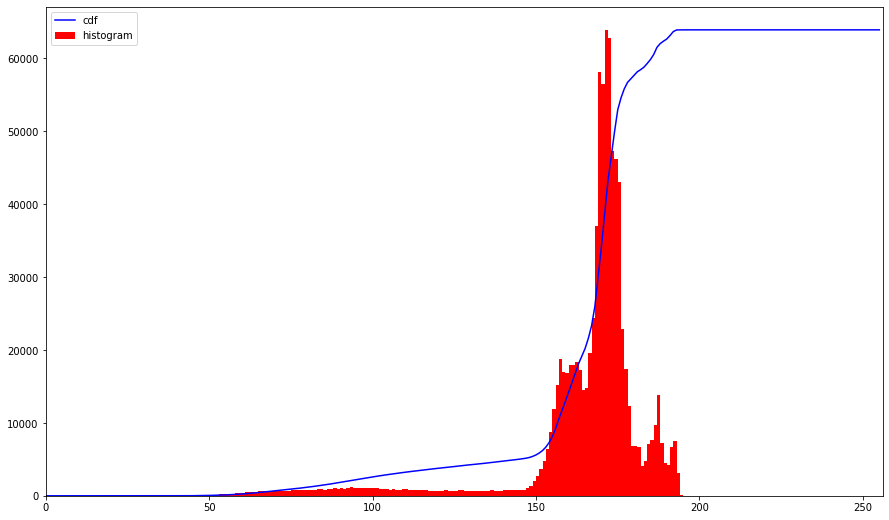

In [9]:
histogram(img, show=True)

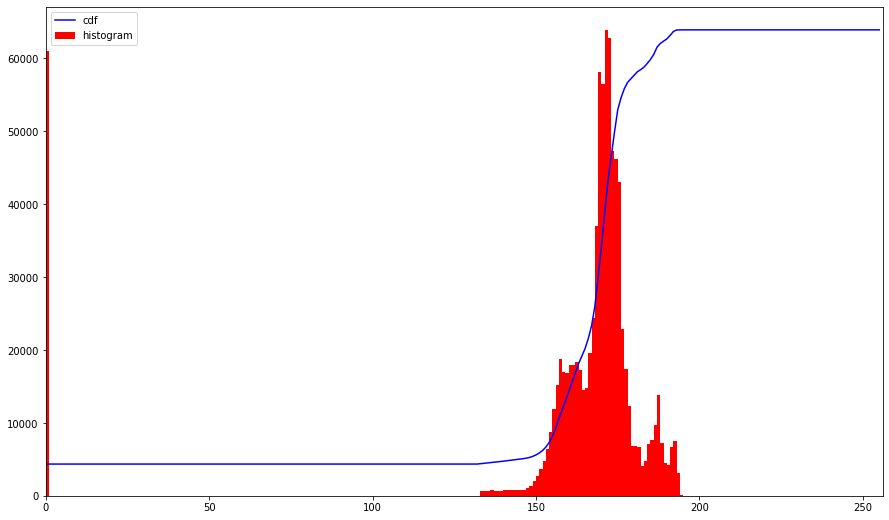

In [10]:
histogram(th1, show=True)

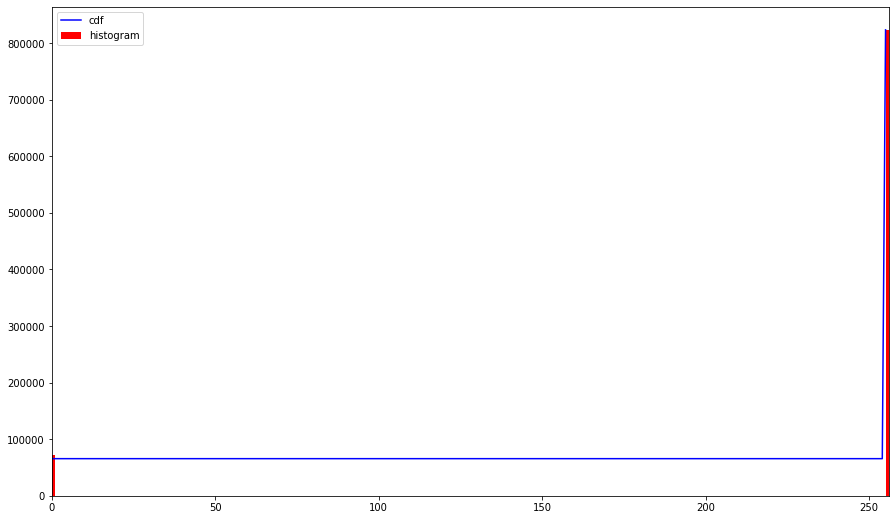

In [11]:
histogram(th2, show=True)

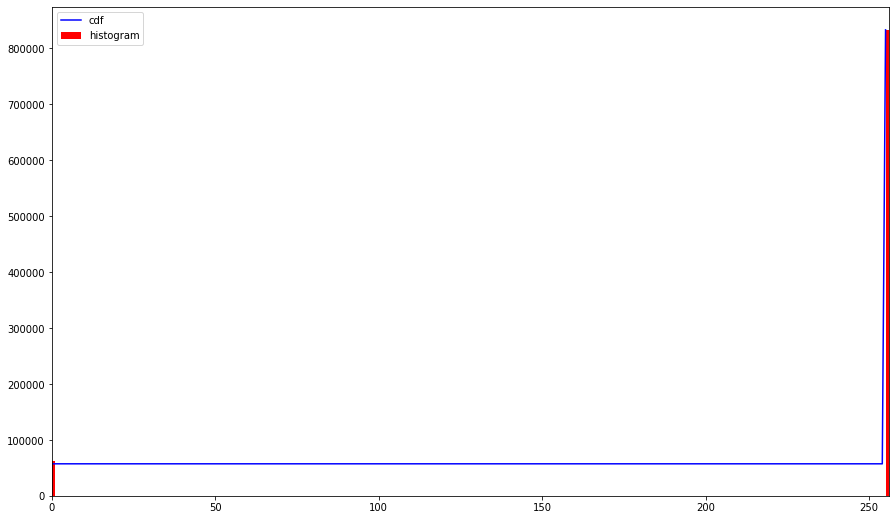

In [12]:
histogram(th3, show=True)

# Histograms Equalization in OpenCV
### ! not working well

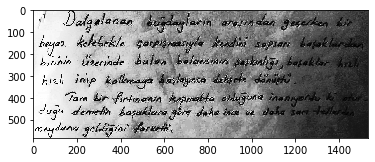

In [13]:
equ = cv2.equalizeHist(image.asnumpy())
# res = np.hstack((image,equ)) #stacking images side-by-side
plt.imshow(equ, cmap="gray")
plt.show()

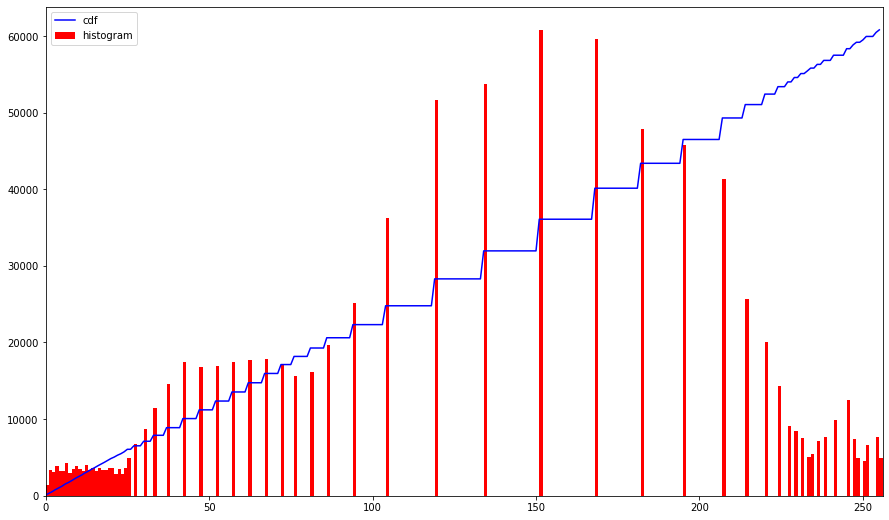

In [14]:
histogram(equ, show=True)

# CLAHE (Contrast Limited Adaptive Histogram Equalization)

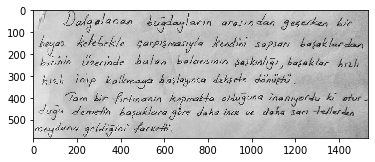

In [15]:
# create a CLAHE object (Arguments are optional).
def CLAHE(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(img)
    return cl1

cl1 = CLAHE(image.asnumpy())
plt.imshow(cl1, cmap="gray")
plt.show()

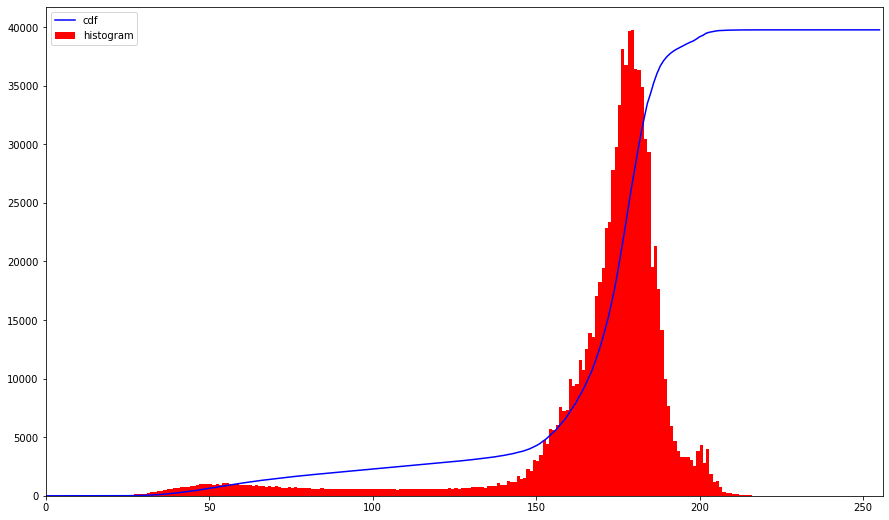

In [16]:
histogram(cl1, show=True)

Remove low

# Edge Detections

## Canny
### ! not working well

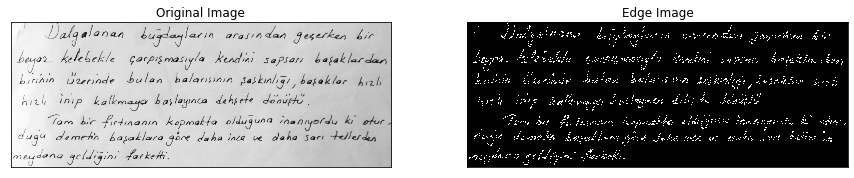

In [17]:
canny_edges = cv2.Canny(image.asnumpy(),100,200)

fig, ax = plt.subplots(1, figsize=(15, 10))
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(canny_edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

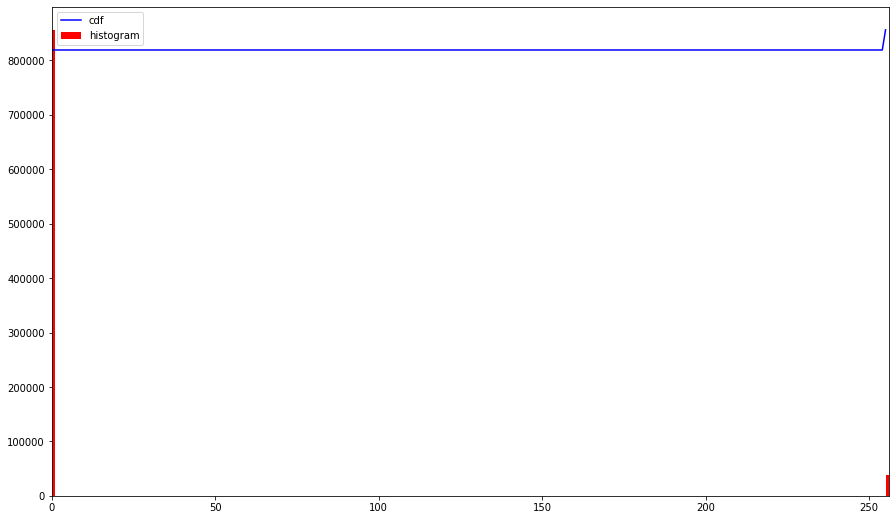

In [18]:
histogram(canny_edges, show=True)

## Laplacian and Sobel
Handwritten become unreadable while kernel_size decreasing.

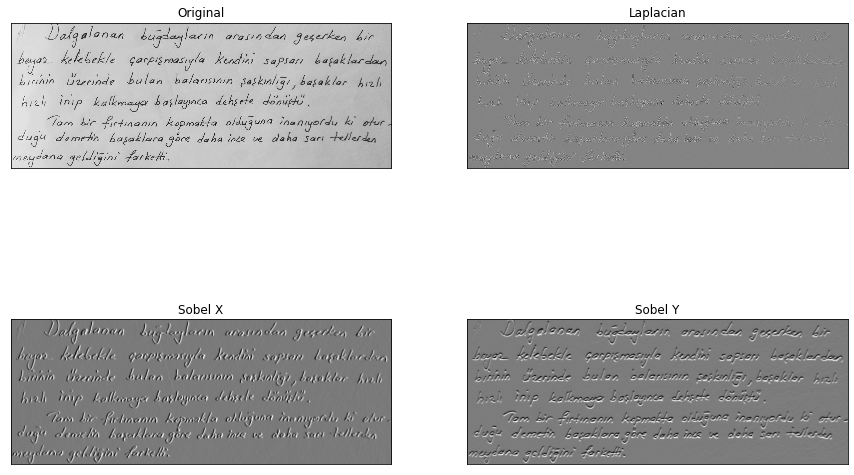

In [19]:
img = image.asnumpy()
# kernel
kernel_size = 21  # odd number, 5
laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=kernel_size)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=kernel_size)


fig, ax = plt.subplots(1, figsize=(15, 10))
plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

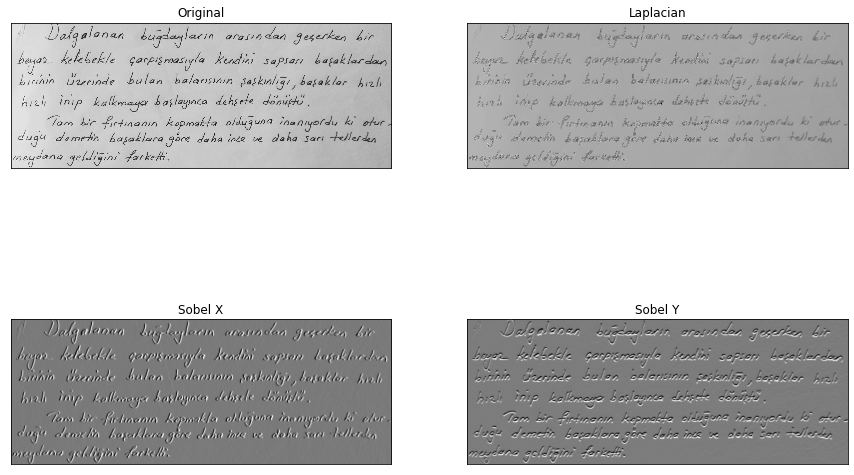

In [20]:
fig, ax = plt.subplots(1, figsize=(15, 10))
plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,2),plt.imshow(img+laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])

# img+sobel not changes
plt.subplot(2,2,3),plt.imshow(img+sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,4),plt.imshow(img+sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show()

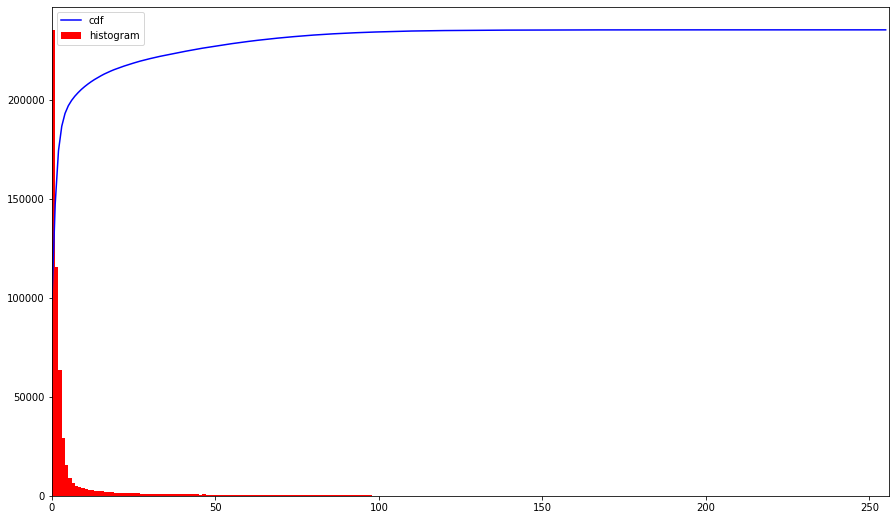

In [21]:
histogram(laplacian, show=True)

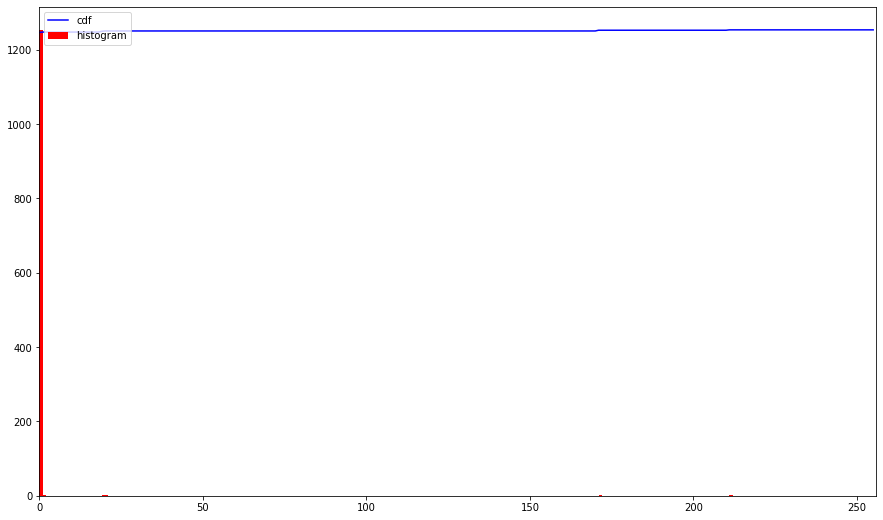

In [22]:
histogram(sobelx, show=True)

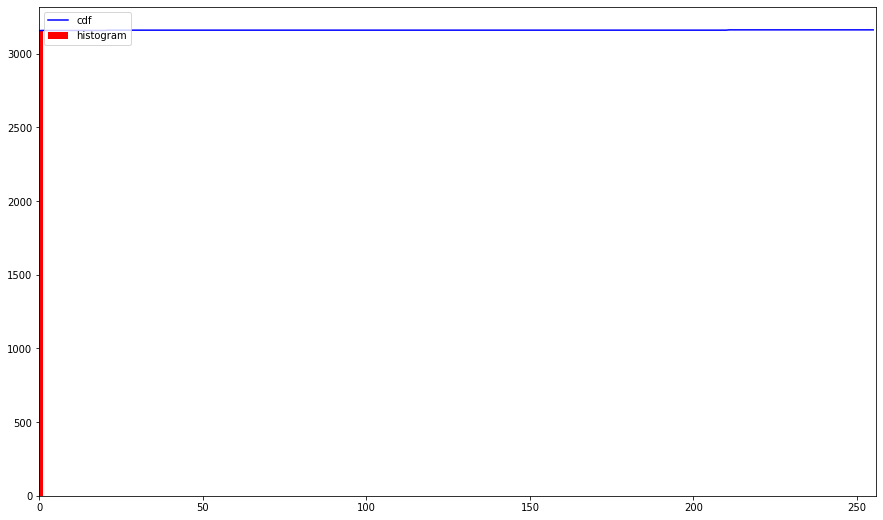

In [23]:
histogram(sobely, show=True)

# Combinations

In [24]:
# CLAHE
img = image.asnumpy()
cl1 = CLAHE(img)
[img, th1, th2, th3] = thresholds(img, 127, 255)

# kernel
kernel_size = 21  # odd number, 5
laplacian = cv2.Laplacian(th1,cv2.CV_64F)
sobelx = cv2.Sobel(th1,cv2.CV_64F,1,0,ksize=kernel_size)
sobely = cv2.Sobel(th1,cv2.CV_64F,0,1,ksize=kernel_size)

img = th1  # cv2.equalizeHist(sobelx+sobely+laplacian)

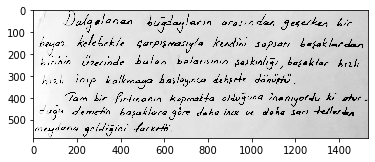

In [25]:
plt.imshow(img, cmap="gray")
plt.show()

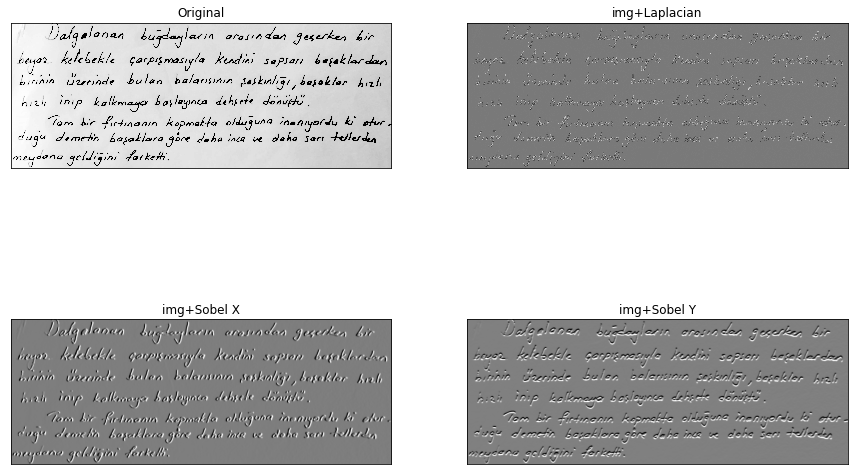

In [26]:
fig, ax = plt.subplots(1, figsize=(15, 10))
plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('img+Laplacian'), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('img+Sobel X'), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('img+Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

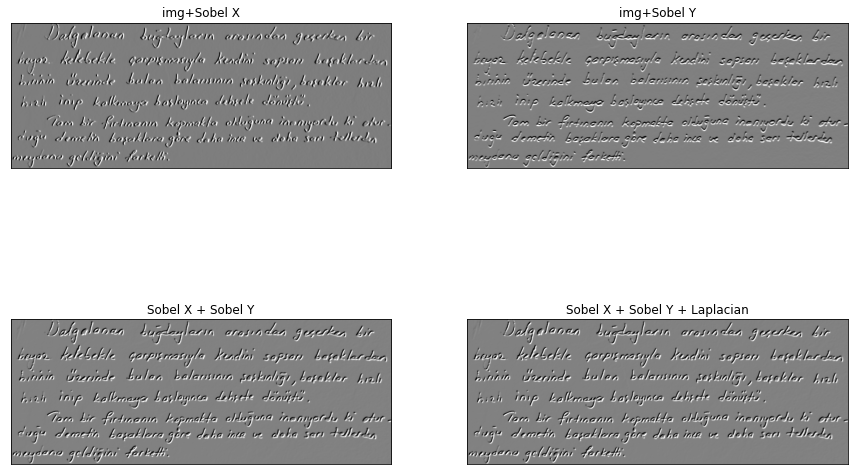

In [27]:
fig, ax = plt.subplots(1, figsize=(15, 10))

plt.subplot(2,2,1),plt.imshow(img+sobelx,cmap = 'gray')
plt.title('img+Sobel X'), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,2),plt.imshow(img+sobely,cmap = 'gray')
plt.title('img+Sobel Y'), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,3),plt.imshow(sobelx+sobely,cmap = 'gray')
plt.title('Sobel X + Sobel Y'), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,4),plt.imshow(sobelx+sobely+laplacian,cmap = 'gray')
plt.title('Sobel X + Sobel Y + Laplacian'), plt.xticks([]), plt.yticks([])

plt.show()

In [28]:
def thresholds(image, bottom=127, top=255):
    # img = cv2.medianBlur(image,5)
    ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO+cv2.THRESH_OTSU)  # Global thresholding
    th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
                cv2.THRESH_BINARY,11,2)
    th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                cv2.THRESH_BINARY,11,2)
    return img, th1, th2, th3

cl1 = CLAHE(img)
th = thresholds(cl1, 127, 255)
[image, th1, th2, th3] = th

# kernel
kernel_size = 21  # odd number, 5
laplacian = cv2.Laplacian(th1, cv2.CV_64F)
sobelx = cv2.Sobel(th1, cv2.CV_64F, 1, 0, ksize=kernel_size)
sobely = cv2.Sobel(th1, cv2.CV_64F, 0, 1, ksize=kernel_size)

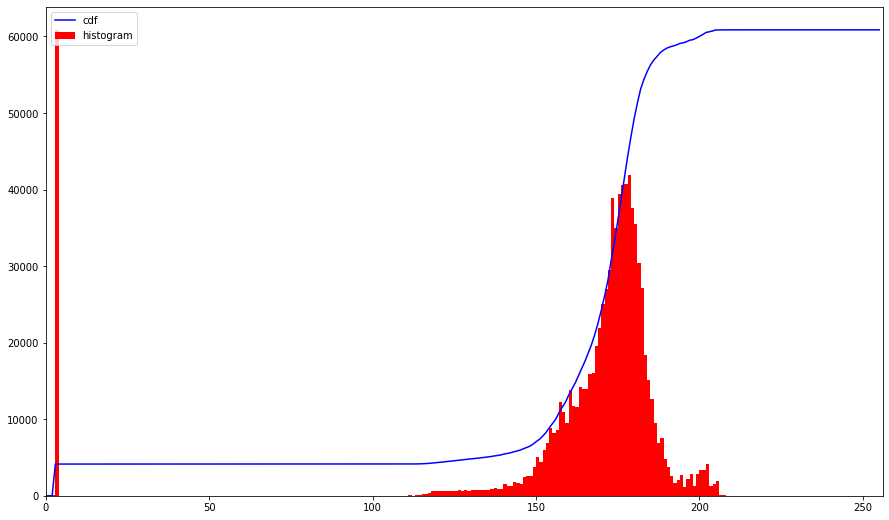

In [29]:
histogram(cl1)

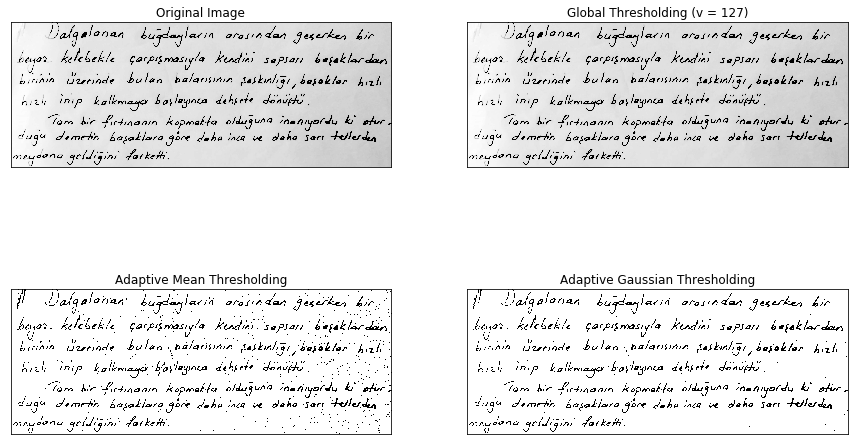

In [30]:
titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]

fig, ax = plt.subplots(1, figsize=(15, 9))
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()
fig.savefig("elyaz_thresholds.png")